# VGG-16

## Install Libraries

In [1]:
%pip install tensorflow tensorflow-datasets matplotlib pydot


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

2024-07-15 09:31:13.275308: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 09:31:13.282606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 09:31:13.304223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:31:13.330331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:31:13.339863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 09:31:13.360017: I tensorflow/core/platform/cpu_feature_gu

## Load Data

In [3]:
(train_data, test_data), info = tfds.load('cifar10',
                                          split=('train[:40%]', 'train[40%:50%]'),
                                          with_info=True,
                                          as_supervised=True)

## Data Exploration

In [4]:
len(train_data), len(test_data)

(20000, 5000)

In [5]:
for X, y in train_data:
    print(X.shape, y.numpy())
    image_1 = X.numpy()
    break

(32, 32, 3) 7


2024-07-15 09:31:16.964002: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


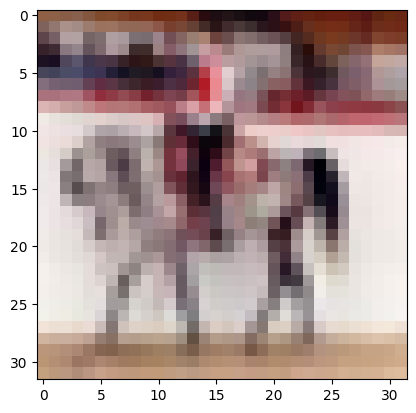

In [6]:
plt.imshow(image_1)

## Preprocess Data

In [7]:
def normalize_img(image, label):
    label = tf.one_hot(label, depth=10)
    return ((tf.cast(image, tf.float32)) / 255.0, label)

def resize(image, label):
    return (tf.image.resize(image, (224,224)), label)

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

def augment(image, label):
    return data_augmentation(image), label

In [8]:
train_data = train_data.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
SHUFFLE_VAL = len(train_data) // 1000
BATCH_SIZE = 32

train_data = train_data.shuffle(SHUFFLE_VAL)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [10]:
test_data = test_data.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

## Building the Model

In [11]:
model = Sequential(layers=[
    Input(shape=(224, 224, 3)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=4096, activation='relu'),
    Dense(units=10, activation='softmax'),
])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,711,434 (510.07 MB)

 Trainable params: 133,711,434 (510.07 MB)

 Non-trainable params: 0 (0.00 B)

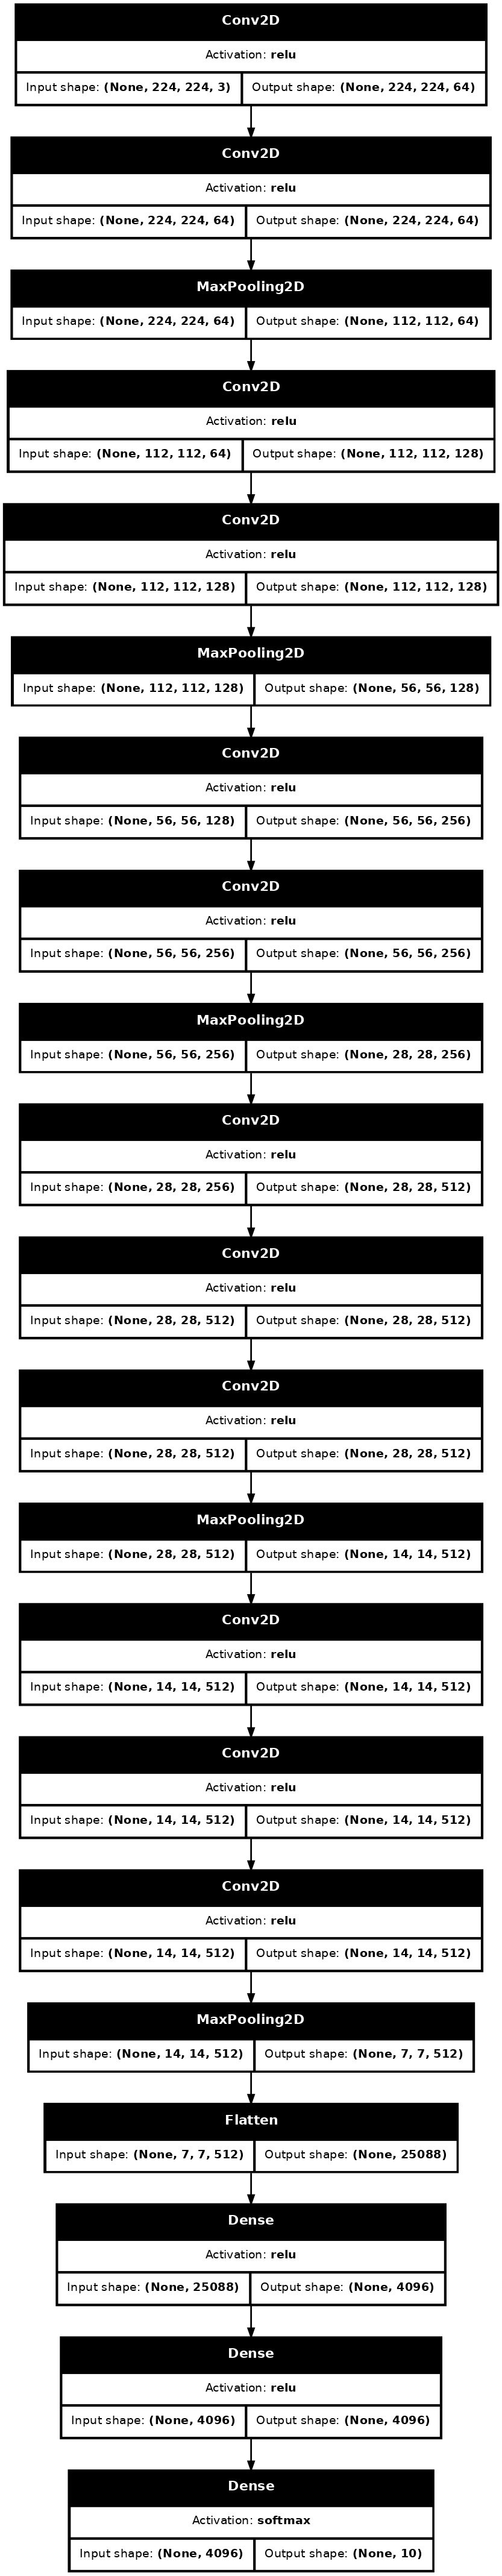

In [13]:
plot_model(model,
           to_file='./images/model_architecture.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=False,
           show_layer_activations=True,
           dpi=100)

In [14]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
es = EarlyStopping(patience=10,
                   monitor='val_loss',
                   restore_best_weights=True)

In [16]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=test_data,
                    callbacks=[es])

Epoch 1/10
 39/625 ━━━━━━━━━━━━━━━━━━━━ 3:12:44 20s/step - accuracy: 0.0939 - loss: 35.0617

KeyboardInterrupt: 